In [55]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os
from sklearn.model_selection import train_test_split

In [56]:
# Define the new directories based on the restructured dataset
base_dir = 'Dataset'

In [57]:
# Image parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training ImageDataGenerator (only rescaling to preserve clarity)
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizes pixel values to [0,1]
    fill_mode='nearest'  # Ensure any padding preserves the image structure
)

# Validation ImageDataGenerator (only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255  # Only rescaling for validation to keep original resolution
)

# Updated directories after splitting the dataset
train_dir = 'Dataset_Train'
val_dir = 'Dataset_Val'


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Set this to the desired image resolution
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Categorical mode for multi-class classification
    shuffle=True,              # Shuffle the data
    seed=42                    # Optional: set a seed for reproducibility
)



# Validation generator - loading images from the validation directory
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # 3 classes
)


Found 144 images belonging to 3 classes.
Found 34 images belonging to 3 classes.


In [65]:
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Number of images in generator: {train_generator.samples}")
print(f"Classes: {train_generator.class_indices}")


Number of classes: 3
Number of images in generator: 144
Classes: {'IR Patch': 0, 'Negative Patch': 1, 'Positive Patch': 2}


In [76]:
unique_classes, counts = np.unique(train_generator.classes, return_counts=True)
print(dict(zip(unique_classes, counts)))


{0: 35, 1: 49, 2: 60}


In [77]:
print("File paths loaded:")
print(train_generator.filenames)


File paths loaded:
['IR Patch\\DSC_0428.JPG', 'IR Patch\\DSC_0429.JPG', 'IR Patch\\DSC_2141.JPG', 'IR Patch\\DSC_6387.JPG', 'IR Patch\\DSC_6388.JPG', 'IR Patch\\DSC_6389.JPG', 'IR Patch\\IMG-20141127-WA0008.jpg', 'IR Patch\\IMG_20130919_112349.jpg', 'IR Patch\\IMG_20131014_104024.jpg', 'IR Patch\\IR with poisitve 2.jpeg', 'IR Patch\\IR with positive 1.jpeg', 'IR Patch\\Positive with IR  5.jpeg', 'IR Patch\\Positive with IR 2.JPG', 'IR Patch\\Positive with IR 3.jpg', 'IR Patch\\Positive with IR 4.jpeg', 'IR Patch\\Positive with IR.JPG', 'IR Patch\\WhatsApp Image 2023-09-28 at 20.20.53.jpeg', 'IR Patch\\WhatsApp Image 2024-09-05 at 08.39.32.jpeg', 'IR Patch\\WhatsApp Image 2024-09-05 at 08.39.37.jpeg', 'IR Patch\\WhatsApp Image 2024-09-05 at 08.39.47.jpeg', 'IR Patch\\photo1673669459.jpeg', 'IR Patch\\photo1673671286 (24).jpeg', 'IR Patch\\photo1676726355 (4).jpeg', 'IR Patch\\photo1676726355 (5).jpeg', 'IR Patch\\photo1682436241.jpeg', 'IR Patch\\photo1682828770 (7).jpeg', 'IR Patch\\ph

In [78]:
# Check the new class indices to ensure all four are recognized
print("Detected class indices:", train_generator.class_indices)

Detected class indices: {'IR Patch': 0, 'Negative Patch': 1, 'Positive Patch': 2}


In [79]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model, excluding the fully connected layers at the top
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the ResNet50 base model to retain pre-trained weights
base_model.trainable = False  

# Build the model
model = models.Sequential([
    base_model,  # Use ResNet50 as the feature extractor
    layers.Flatten(),  # Flatten the output of the convolutional base
    layers.Dense(512, activation='relu'),  # Add a fully connected layer
    layers.Dropout(0.5),  # Add dropout to reduce overfitting
    layers.Dense(3, activation='softmax')  # Output layer for 4 classes
])


model.add(tf.keras.layers.Dense(3, activation='softmax'))  # Update to 3 classes

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])



In [80]:
import pandas as pd
import numpy as np

# Initialize lists to store file paths and classes
file_paths = []
classes = []

# Reset the generator to ensure we can iterate over it
train_generator.reset()

# Print the number of classes and filenames to debug
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Number of images in generator: {len(train_generator.filenames)}")

# Get the total number of batches
total_batches = len(train_generator)

# Iterate through the train_generator
for batch_index in range(total_batches):
    batch_images, batch_labels = train_generator.next()  # Get the next batch
    
    # Print batch size for debugging
    print(f"Batch {batch_index + 1}/{total_batches}, Images in batch: {len(batch_labels)}")

    # Extract class indices from one-hot encoded labels
    for i in range(len(batch_labels)):
        class_index = np.argmax(batch_labels[i])  # Get class index
        
        # Use the filenames directly from the generator
        # Ensure we don't exceed the length of filenames
        if batch_index * train_generator.batch_size + i < len(train_generator.filenames):
            file_path = train_generator.filenames[batch_index * train_generator.batch_size + i]
            file_paths.append(file_path)
            classes.append(class_index)

# Create the DataFrame
df = pd.DataFrame({'class': classes, 'data': file_paths})

# Print the resulting DataFrame
print(f"DataFrame shape: {df.shape}")
print(df.head())

# Example of filtering for the majority class
if not df.empty:
    df_majority = df[df['class'] == 2]  # Assume class 2 is the majority
    df_minority_0 = df[df['class'] == 0]
else:
    print("The DataFrame is empty, no data to filter.")


Number of classes: 3
Number of images in generator: 144
Batch 1/5, Images in batch: 32
Batch 2/5, Images in batch: 32
Batch 3/5, Images in batch: 32
Batch 4/5, Images in batch: 32
Batch 5/5, Images in batch: 16
DataFrame shape: (144, 2)
   class                   data
0      2  IR Patch\DSC_0428.JPG
1      1  IR Patch\DSC_0429.JPG
2      2  IR Patch\DSC_2141.JPG
3      1  IR Patch\DSC_6387.JPG
4      0  IR Patch\DSC_6388.JPG


In [81]:
import pandas as pd
from sklearn.utils import resample

# Create a DataFrame from the train_generator
df = pd.DataFrame({
    'class': train_generator.classes,        # Class indices
    'filename': train_generator.filenames     # Corresponding filenames
})

# Check the DataFrame
print("DataFrame shape:", df.shape)
print("Unique classes and counts:", df['class'].value_counts())

# Filter the majority and minority classes
df_majority = df[df['class'] == 2]  # Assuming class 2 is the majority (Positive)
df_minority_0 = df[df['class'] == 0] # Class 0 (Negative)
df_minority_1 = df[df['class'] == 1] # Class 1 (IR)

# Upsample the minority classes
df_minority_0_upsampled = resample(df_minority_0,
                                   replace=True,     # sample with replacement
                                   n_samples=len(df_majority), # Match the majority class
                                   random_state=123) # reproducible results

df_minority_1_upsampled = resample(df_minority_1,
                                   replace=True,
                                   n_samples=len(df_majority),
                                   random_state=123)

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority, df_minority_0_upsampled, df_minority_1_upsampled])

# Downsample the majority class to match the size of one of the minority classes
df_majority_downsampled = resample(df_majority,
                                    replace=False,  # sample without replacement
                                    n_samples=min(len(df_minority_0), len(df_minority_1)), # Match the size of the smaller minority class
                                    random_state=123) # reproducible results

# Combine downsampled majority class with original minority classes
df_downsampled = pd.concat([df_majority_downsampled, df_minority_0, df_minority_1])

# Check class distribution
print("Upsampled DataFrame shape:", df_upsampled.shape)
print("Downsampled DataFrame shape:", df_downsampled.shape)
print("Class distribution after balancing:")
print(df_downsampled['class'].value_counts())

# Define class weights for training
class_weights = {0: 1.0, 1: 1.5, 2: 0.75}  # Adjust these weights based on the counts


DataFrame shape: (144, 2)
Unique classes and counts: class
2    60
1    49
0    35
Name: count, dtype: int64
Upsampled DataFrame shape: (180, 2)
Downsampled DataFrame shape: (119, 2)
Class distribution after balancing:
class
1    49
2    35
0    35
Name: count, dtype: int64


In [82]:
# Class weights can be defined if needed (example values)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define class weights based on your unique classes
class_weights = {0: 1.0, 1: 2.0, 2: 3.0}  # Adjust weights if needed
epochs = 50

# Fit the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping],
    class_weight=class_weights  # Use the class weights
)



# Verify shapes before training
for data, labels in train_generator:
    print(data.shape)  # Should be (batch_size, 150, 150, 3)
    print(labels.shape)  # Should be (batch_size, 3)
    break  # Check only the first batch

Epoch 1/50
5/5 [==============================] - 59s 7s/step - loss: 2.6651 - accuracy: 0.3403 - val_loss: 1.1445 - val_accuracy: 0.3529
Epoch 2/50
5/5 [==============================] - 30s 6s/step - loss: 2.3643 - accuracy: 0.5000 - val_loss: 1.1349 - val_accuracy: 0.3529
Epoch 3/50
5/5 [==============================] - 29s 5s/step - loss: 2.2108 - accuracy: 0.6389 - val_loss: 1.1273 - val_accuracy: 0.3529
Epoch 4/50
5/5 [==============================] - 31s 7s/step - loss: 2.1557 - accuracy: 0.7153 - val_loss: 1.1261 - val_accuracy: 0.3529
Epoch 5/50
5/5 [==============================] - 31s 6s/step - loss: 2.0828 - accuracy: 0.7708 - val_loss: 1.1288 - val_accuracy: 0.3529
Epoch 6/50
5/5 [==============================] - 28s 5s/step - loss: 2.0883 - accuracy: 0.7778 - val_loss: 1.1299 - val_accuracy: 0.3529
Epoch 7/50
5/5 [==============================] - 19s 3s/step - loss: 2.0174 - accuracy: 0.8472 - val_loss: 1.1289 - val_accuracy: 0.3529
Epoch 8/50
5/5 [==================

In [83]:
# Import necessary libraries
from tensorflow.keras.models import load_model

# Save the model as an HDF5 file
model.save('medical_model.h5')  # Save the model in HDF5 format


C:\Users\Kavana K\anaconda3\envs\myenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [84]:
import pickle

# Save model architecture and weights separately
model_json = model.to_json()  # Get model architecture
with open("medical_model.json", "w") as json_file:
    json_file.write(model_json)

# Save weights
model.save_weights("medical_model_weights.h5")

# Save to a .pkl file
with open('medical_model.pkl', 'wb') as pkl_file:
    pickle.dump({'model_json': model_json, 'model_weights': 'medical_model_weights.h5'}, pkl_file)


Found 145 images belonging to 3 classes.
5/5 [==============================] - 8s 2s/step
[[ 0 35  0]
 [ 0 49  0]
 [ 0 61  0]]
                precision    recall  f1-score   support

      IR Patch       0.00      0.00      0.00        35
Negative Patch       0.34      1.00      0.51        49
Positive Patch       0.00      0.00      0.00        61

      accuracy                           0.34       145
     macro avg       0.11      0.33      0.17       145
  weighted avg       0.11      0.34      0.17       145



C:\Users\Kavana K\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kavana K\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kavana K\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


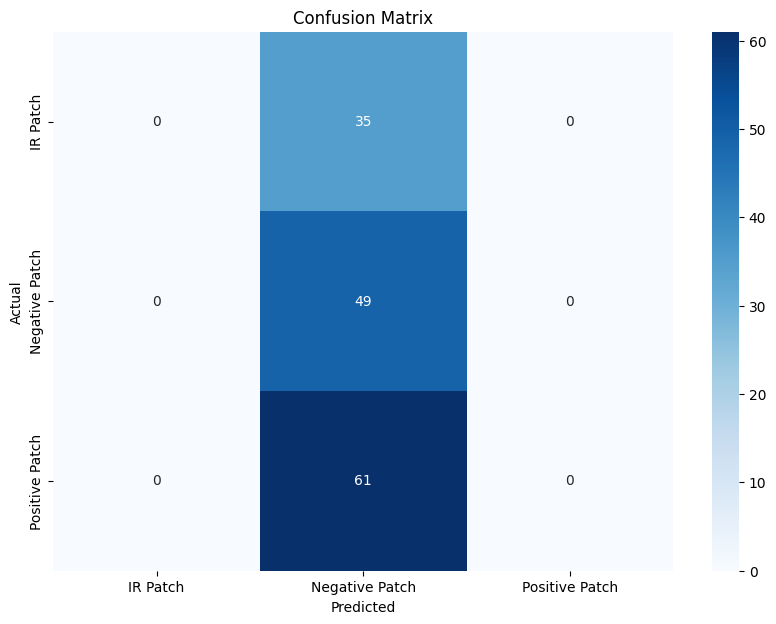

In [87]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming you have test data and true labels
test_data_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix
)
class_mapping = {
    0: 'IR Patch',
    1: 'Negative Patch',
    2: 'Positive Patch'
}

# Get predictions
y_pred = model.predict(test_data_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_data_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_mapping.values()))

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
